In [1]:
import pandas as pd
import numpy as np
import pickle as cPickle
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, TheilSenRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import collections
from sklearn.manifold import TSNE
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_log_error


2023-06-22 21:11:36.557665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define Helper functions
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# from scipy.stats import pearsonr
def pearson_corr(y_true, y_pred):
    return pearsonr(y_true, y_pred)[0]

# from sklearn.metrics import mean_squared_log_error
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def adjusted_r2(y_true, y_pred, n_features):
    n = len(y_true)
    r2 = 1 - (np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2))
    adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - n_features - 1)
    return adjusted_r2

def plot_residuals(y_true, y_pred):
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.show()

In [3]:
df = pd.read_csv('inmuebles.csv')

In [4]:
df.head()

,Unnamed: 0,titulo,provincia,localidad,distrito,tipovivienda,precio,metros,habitaciones,baños,...,equipada,amueblada,orientacion,anyoconstruccion,garaje,terraza,calefaccion,aireacondicionado,created_at,updated_at
0,0,"Alquiler de Ático en calle de Embajadores, 296",Madrid,Legazpi Madrid,arganzuela,Ático,3200,107,4.0,3.0,...,1,1,NaN,NaN,0,1,0,1,2023-06-03 09:29:50,2023-06-03 09:29:50
1,1,Alquiler de Piso en calle de las Nebulosas,Madrid,Delicias Madrid,arganzuela,Piso,1340,75,2.0,2.0,...,1,1,NaN,2014.0,0,0,individual,1,2023-06-03 09:29:50,2023-06-03 09:29:50
2,2,Alquiler de Piso en calle de las Delicias,Madrid,Palos de Moguer Madrid,arganzuela,Piso,975,60,2.0,1.0,...,1,1,NaN,1935.0,0,0,individual,0,2023-06-03 09:29:50,2023-06-03 09:29:50
3,3,Alquiler de Piso en Delicias,Madrid,Arganzuela Madrid,arganzuela,Piso,800,60,1.0,1.0,...,1,0,oeste,NaN,0,0,0,1,2023-06-03 09:29:50,2023-06-03 09:29:50
4,4,"Alquiler de Piso en Fernando Poo, 23",Madrid,Chopera Madrid,arganzuela,Piso,1400,84,3.0,1.0,...,1,1,norte,1968.0,0,1,individual,0,2023-06-03 09:29:50,2023-06-03 09:29:50


In [5]:
# Modificar 'localidad'
df['localidad'] = df['localidad'].str.replace('Madrid', '').str.lower()
df['localidad'] = df['localidad'].str.replace(' ', '')
df['distrito'] = df['distrito'].str.replace(' ', '')
len(df[df['localidad'] == df['distrito']])

346

In [6]:
df_filtered = df[df['localidad'] != df['distrito']]

In [7]:
df_filtered.duplicated().sum()

0

In [8]:
len(df_filtered[df_filtered['precio'] > 5000])

166

In [9]:
df_filtered = df_filtered[df_filtered['precio'] <= 5000]

In [10]:
len(df_filtered[df_filtered['metros'] > 400])

7

In [11]:
df_filtered = df_filtered[df_filtered['metros'] <= 400]

In [12]:
df_filtered.isnull().sum()

Unnamed: 0              0
titulo                  0
provincia               0
localidad               0
distrito                0
tipovivienda           29
precio                  0
metros                  0
habitaciones          238
baños                   2
planta                272
ascensor               33
exterior              187
equipada                0
amueblada               0
orientacion          2477
anyoconstruccion     2986
garaje                  0
terraza                 0
calefaccion             0
aireacondicionado       0
created_at              0
updated_at              0
dtype: int64

In [13]:
columns_to_drop = ['created_at', 'updated_at', 'anyoconstruccion', 'orientacion', 'Unnamed: 0']
df_filtered = df_filtered.drop(columns=columns_to_drop)

In [14]:
corr = df_filtered.corr()
corr.style.background_gradient(cmap='coolwarm')

/tmp/ipykernel_28648/66163735.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_filtered.corr()


,precio,metros,habitaciones,baños,planta,ascensor,exterior,equipada,amueblada,garaje,terraza,aireacondicionado
precio,1.000000,0.720354,0.457263,0.696585,0.176583,0.279663,0.104612,0.099180,0.051844,0.088397,0.088396,0.288988
metros,0.720354,1.000000,0.710154,0.805911,0.190973,0.249257,0.209273,0.017080,-0.188175,0.302887,0.213166,0.178144
habitaciones,0.457263,0.710154,1.000000,0.635873,0.121676,0.079559,0.157008,-0.009167,-0.175622,0.126648,0.149352,-0.032500
baños,0.696585,0.805911,0.635873,1.000000,0.150827,0.250963,0.162943,0.050293,-0.143217,0.281638,0.138352,0.209398
planta,0.176583,0.190973,0.121676,0.150827,1.000000,0.237877,0.107495,0.022309,-0.043231,0.153285,0.188777,0.159192
ascensor,0.279663,0.249257,0.079559,0.250963,0.237877,1.000000,0.002401,0.023391,0.006062,0.245498,0.039896,0.208111
exterior,0.104612,0.209273,0.157008,0.162943,0.107495,0.002401,1.000000,-0.071317,-0.188851,0.202650,0.195244,0.072724
equipada,0.099180,0.017080,-0.009167,0.050293,0.022309,0.023391,-0.071317,1.000000,0.331945,-0.028143,-0.033954,0.120504
amueblada,0.051844,-0.188175,-0.175622,-0.143217,-0.043231,0.006062,-0.188851,0.331945,1.000000,-0.211566,-0.117220,0.113879
garaje,0.088397,0.302887,0.126648,0.281638,0.153285,0.245498,0.202650,-0.028143,-0.211566,1.000000,0.125422,0.179631


In [15]:
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4583 entries, 0 to 5101
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   titulo             4583 non-null   object 
 1   provincia          4583 non-null   object 
 2   localidad          4583 non-null   object 
 3   distrito           4583 non-null   object 
 4   tipovivienda       4554 non-null   object 
 5   precio             4583 non-null   int64  
 6   metros             4583 non-null   int64  
 7   habitaciones       4345 non-null   float64
 8   baños              4581 non-null   float64
 9   planta             4311 non-null   float64
 10  ascensor           4550 non-null   float64
 11  exterior           4396 non-null   float64
 12  equipada           4583 non-null   int64  
 13  amueblada          4583 non-null   int64  
 14  garaje             4583 non-null   int64  
 15  terraza            4583 non-null   int64  
 16  calefaccion        4583 

In [16]:
# from sklearn.preprocessing import OneHotEncoder

# Columnas a codificar
columnas_codificar = ['distrito', 'tipovivienda', 'calefaccion', 'localidad']

# Copia del DataFrame original
df_encoded = df_filtered.copy()

# Crear instancia de OneHotEncoder
encoder = OneHotEncoder()

# Codificar columnas
encoded_columns = encoder.fit_transform(df_filtered[columnas_codificar]).toarray()

# Crear nombres de columnas codificadas
encoded_column_names = encoder.get_feature_names_out(columnas_codificar)

# Crear DataFrame de columnas codificadas
df_encoded = pd.concat([df_encoded, pd.DataFrame(encoded_columns, columns=encoded_column_names)], axis=1)

In [17]:
df_encoded.dropna(inplace=True)

In [18]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3534 entries, 0 to 4582
Columns: 174 entries, titulo to localidad_zofío
dtypes: float64(168), object(6)
memory usage: 4.7+ MB


In [19]:
# Seleccionar las características numéricas y la variable objetivo
numeric_features = df_encoded.select_dtypes(include=np.number).columns.tolist()
numeric_features.remove('precio')

# Seleccionar las características y la variable objetivo
features = numeric_features
target = 'precio'

# Reemplazar las características con las columnas numéricas
X = df_encoded[features]
y = df_encoded[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo Random Forest y evaluar su desempeño en los conjuntos de entrenamiento y prueba
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

training_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Training score: {training_score:.3f}")
print(f"Test score: {test_score:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")

# Calcular el MAPE
mape_score = mape(y_test, y_pred)
print(f"MAPE: {mape_score}")

# Calcular la correlación de Pearson
pearson_corr_score = pearson_corr(y_test, y_pred)
print(f"Pearson correlation: {pearson_corr_score}")

# Calcular el RMSLE
rmsle_score = rmsle(y_test, y_pred)
print(f"RMSLE: {rmsle_score}")

# Crear una lista de modelos
modelos = [
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    PLSRegression(),
    XGBRegressor(),
    DecisionTreeRegressor(),
]

best_model = None
best_r2 = -float('inf')
best_mse = float('inf')
best_mae = float('inf')
best_score = -float('inf')  # Mejor puntuación promedio

# Iterar sobre la lista de modelos y evaluar su desempeño
for modelo in modelos:
    modelo.fit(X_train, y_train)
    predicciones = modelo.predict(X_test)
    r2 = r2_score(y_test, predicciones)
    mse = mean_squared_error(y_test, predicciones)
    mae = mean_absolute_error(y_test, predicciones)

    # Verificar si el modelo actual tiene un mejor rendimiento en términos de R^2, MSE, MAE y puntuación promedio
    scores = cross_val_score(modelo, X, y, cv=5)
    score_mean = scores.mean()  # Puntuación promedio

    if (r2 > best_r2 or (r2 == best_r2 and mse < best_mse) or (r2 == best_r2 and mse == best_mse and mae < best_mae)) and score_mean > best_score:
        best_model = modelo
        best_r2 = r2
        best_mse = mse
        best_mae = mae
        best_score = score_mean

# Utilizar el mejor modelo para hacer predicciones
if best_model is not None and best_score > 0:
    best_model.fit(X, y)
    predicciones = best_model.predict(X)

    scores = cross_val_score(best_model, X, y, cv=5)

    print("Mejor Modelo:")
    print(f"Tipo de modelo: {type(best_model).__name__}")
    print(f"Coeficiente de Determinación (R^2): {best_r2}")
    print(f"Error Medio Cuadrático (MSE): {best_mse}")
    print(f"Error Medio Absoluto (MAE): {best_mae}")
    print(f"Puntuación promedio: {best_score}")


Training score: 0.967
Test score: 0.739
MSE: 196317.210
MAE: 298.410
R^2: 0.739
MAPE: 17.551875371824522
Pearson correlation: 0.8598127292729774
RMSLE: 0.22802340025820556
Mejor Modelo:
Tipo de modelo: RandomForestRegressor
Coeficiente de Determinación (R^2): 0.7412906521959213
Error Medio Cuadrático (MSE): 194706.331298119
Error Medio Absoluto (MAE): 300.3922736916549
Puntuación promedio: 0.7026555769840732


In [20]:
# Agregar las predicciones al DataFrame original
df_encoded['prediccion_precio'] = predicciones
# Convertir el tipo de datos de la columna 'prediccion_precio' a int64
df_encoded['prediccion_precio'] = df_encoded['prediccion_precio'].astype(int)
# Filtrar los pisos con precios por debajo de la predicción
chollos = df_encoded[df_encoded['precio'] < df_encoded['prediccion_precio']]

Adjusted R-squared: 0.9663699338187938
MAPE: 6.310182460149489
Pearson correlation: 0.9853870050872605
RMSLE: 0.08633063504902756


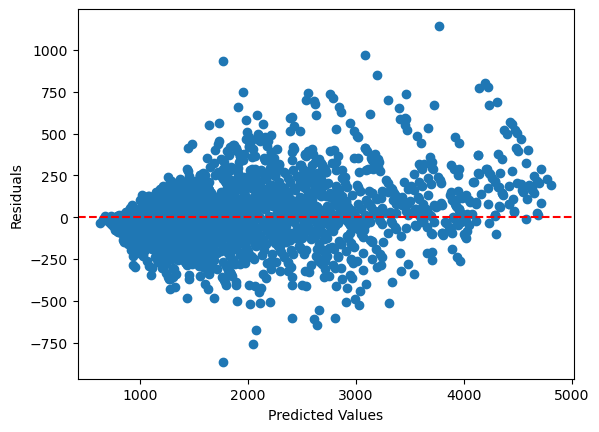

In [21]:
# Ejemplo de uso de las funciones

# Supongamos que tienes los valores reales y las predicciones almacenados en las siguientes variables
y_true = df_encoded['precio']
y_pred = df_encoded['prediccion_precio']

# Calcula el coeficiente de determinación ajustado (adjusted R-squared)
n_features = len(features)
adjusted_r2_score = adjusted_r2(y_true, y_pred, n_features)
print(f"Adjusted R-squared: {adjusted_r2_score}")

# Calcula el error porcentual absoluto medio (MAPE)
mape_score = mape(y_true, y_pred)
print(f"MAPE: {mape_score}")

# Calcula el coeficiente de correlación de Pearson
pearson_corr_score = pearson_corr(y_true, y_pred)
print(f"Pearson correlation: {pearson_corr_score}")

# Calcula la raíz del error cuadrático medio logarítmico (RMSLE)
rmsle_score = rmsle(y_true, y_pred)
print(f"RMSLE: {rmsle_score}")

# Visualiza los residuos
plot_residuals(y_true, y_pred)

In [31]:
# from sklearn.model_selection import GridSearchCV
# Entrenar el modelo Random Forest y evaluar su desempeño en los conjuntos de entrenamiento y prueba
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

training_score = rf.score(X_train, y_train)
test_score = rf.score(X_test, y_test)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Training score: {training_score:.3f}")
print(f"Test score: {test_score:.3f}")
print(f"MSE: {mse:.3f}")
print(f"MAE: {mae:.3f}")
print(f"R^2: {r2:.3f}")

# Realizar validación cruzada
scores = cross_val_score(rf, X, y, cv=5)
print("Cross Validation Scores:")
for fold, score in enumerate(scores):
    print(f"Fold {fold+1}: {score}")
print(f"Average Score: {scores.mean()}")

# Ajustar los parámetros del modelo
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_model_grid = grid_search.best_estimator_
best_score_grid = best_model.score(X_test, y_test)

print(f"Best Model: {best_model_grid}")
print(f"Best Score: {best_score_grid}")
print(f"Best Parameters: {grid_search.best_params_}")

Training score: 0.966
Test score: 0.734
MSE: 200172.335
MAE: 300.931
R^2: 0.734
Cross Validation Scores:
Fold 1: 0.7541502889290098
Fold 2: 0.7069607020832884
Fold 3: 0.6576628651471657
Fold 4: 0.7107536121202629
Fold 5: 0.6922087757876378
Average Score: 0.7043472488134729
Best Model: RandomForestRegressor(n_estimators=200)
Best Score: 0.9652706544908164
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}


In [23]:
chollos['distrito'].value_counts()

arganzuela            243
carabanchel           235
chamberi              214
fuencarral            211
ciudad-lineal         162
chamartin             154
retiro                144
centro                136
salamanca             130
moncloa                98
puente-de-vallecas     98
san-blas               70
hortaleza              37
moratalaz              34
barajas                33
Name: distrito, dtype: int64

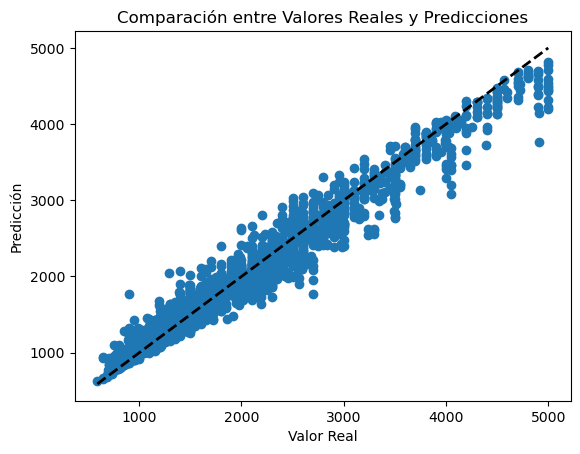

In [24]:
# Crear un gráfico de dispersión de los valores reales frente a las predicciones
plt.scatter(y, predicciones)
plt.plot([min(y), max(y)], [min(y), max(y)], 'k--', lw=2)  # Línea de referencia y = x
plt.xlabel('Valor Real')
plt.ylabel('Predicción')
plt.title('Comparación entre Valores Reales y Predicciones')
plt.show()

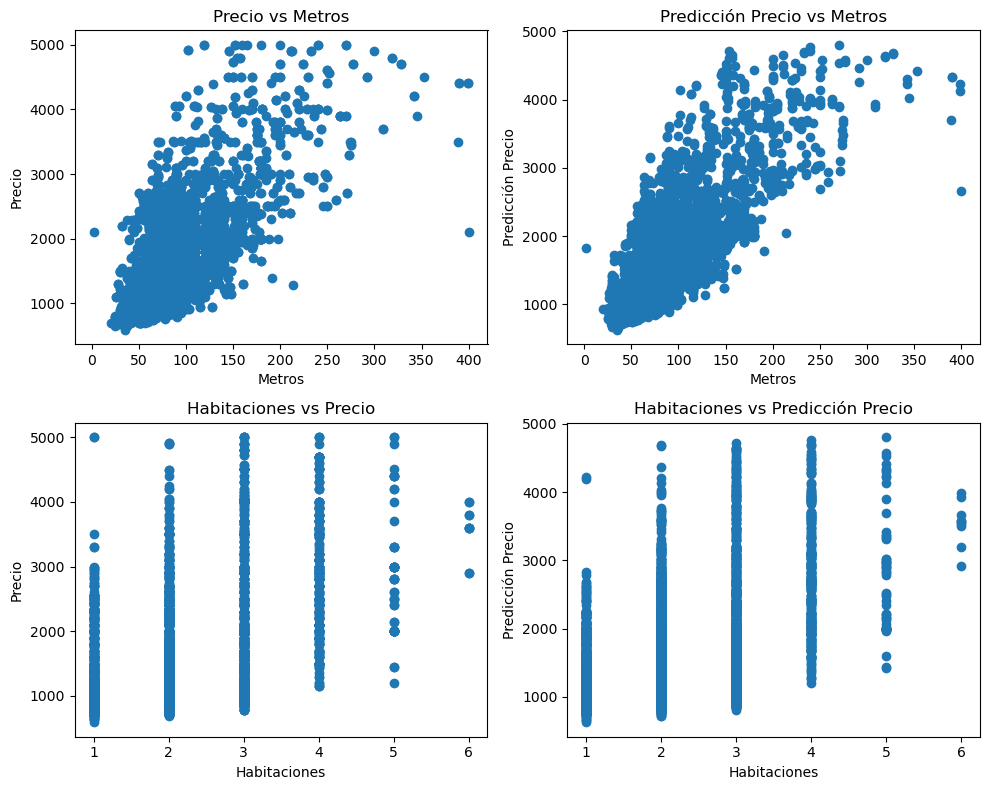

In [25]:
# Crear una figura y varios subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

# Gráfico 1: Precio vs Metros
axes[0, 0].scatter(df_encoded['metros'], df_encoded['precio'])
axes[0, 0].set_xlabel('Metros')
axes[0, 0].set_ylabel('Precio')
axes[0, 0].set_title('Precio vs Metros')

# Gráfico 2: Predicción Precio vs Metros
axes[0, 1].scatter(df_encoded['metros'], df_encoded['prediccion_precio'])
axes[0, 1].set_xlabel('Metros')
axes[0, 1].set_ylabel('Predicción Precio')
axes[0, 1].set_title('Predicción Precio vs Metros')

# Gráfico 3: Habitaciones vs Precio
axes[1, 0].scatter(df_encoded['habitaciones'], df_encoded['precio'])
axes[1, 0].set_xlabel('Habitaciones')
axes[1, 0].set_ylabel('Precio')
axes[1, 0].set_title('Habitaciones vs Precio')

# Gráfico 4: Predicción Precio vs Habitaciones
axes[1, 1].scatter(df_encoded['habitaciones'], df_encoded['prediccion_precio'])
axes[1, 1].set_xlabel('Habitaciones')
axes[1, 1].set_ylabel('Predicción Precio')
axes[1, 1].set_title('Habitaciones vs Predicción Precio')

# Ajustar el espaciado entre subplots
plt.tight_layout()

# Mostrar los gráficos
plt.show()

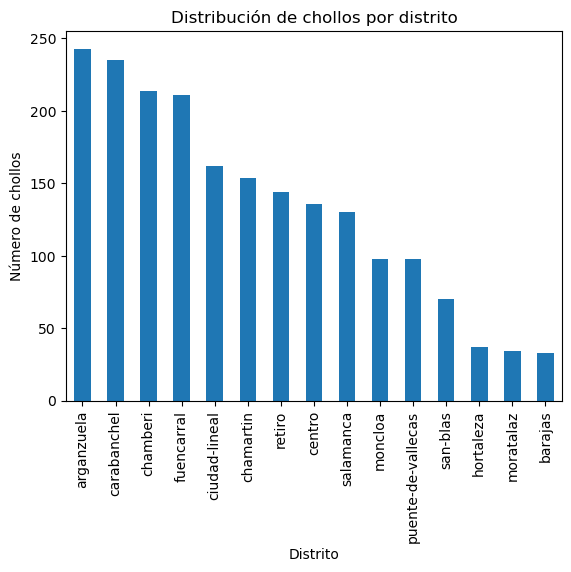

In [26]:
chollos['distrito'].value_counts().plot(kind='bar')
plt.xlabel('Distrito')
plt.ylabel('Número de chollos')
plt.title('Distribución de chollos por distrito')
plt.show()

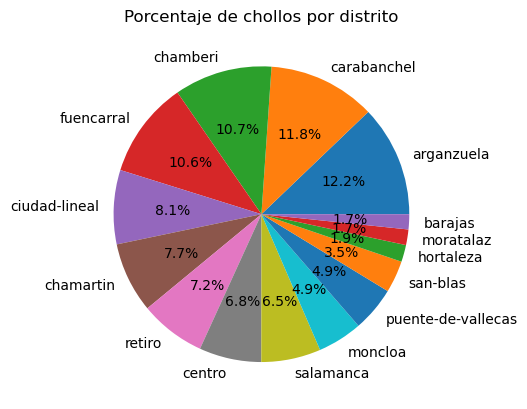

In [27]:
chollos['distrito'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Porcentaje de chollos por distrito')
plt.ylabel('')
plt.show()

In [28]:
chollos['localidad'].value_counts()

prosperidad             139
lavapiés-embajadores     82
palosdemoguer            70
lastablas                49
pacífico                 48
                       ... 
condeorgaz-piovera        2
elpardo                   2
colina                    2
pavones                   1
sanchinarro               1
Name: localidad, Length: 101, dtype: int64

In [29]:
# Calcular la matriz de correlación
correlation_matrix = df_encoded.corr()

# Obtener las correlaciones con la variable 'precio'
precio_correlations = correlation_matrix['precio'].drop('precio')

# Obtener las correlaciones con la variable 'prediccion_precio'
prediccion_correlations = correlation_matrix['prediccion_precio'].drop('prediccion_precio')

# Ordenar las correlaciones de mayor a menor
precio_correlations = precio_correlations.sort_values(ascending=False)
prediccion_correlations = prediccion_correlations.sort_values(ascending=False)

# Imprimir las correlaciones con 'precio'
print("Correlaciones con 'precio':")
print(precio_correlations)

# Imprimir las correlaciones con 'prediccion_precio'
print("\nCorrelaciones con 'prediccion_precio':")
print(prediccion_correlations)

Correlaciones con 'precio':
prediccion_precio                 0.985387
metros                            0.734627
baños                             0.715510
habitaciones                      0.481584
aireacondicionado                 0.286049
                                    ...   
localidad_chueca-justicia        -0.082659
localidad_lavapiés-embajadores   -0.104850
distrito_villaverde              -0.109870
distrito_carabanchel             -0.181380
distrito_centro                  -0.183270
Name: precio, Length: 168, dtype: float64

Correlaciones con 'prediccion_precio':
precio                            0.985387
metros                            0.794609
baños                             0.768706
habitaciones                      0.523814
aireacondicionado                 0.299856
                                    ...   
localidad_chueca-justicia        -0.083481
distrito_villaverde              -0.106778
localidad_lavapiés-embajadores   -0.109282
distrito_carabanchel          

/tmp/ipykernel_28648/550024073.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_encoded.corr()


In [30]:
# Guardamos el modelo en un pickle para poder usarlo en la app
with open('rfModel.pckl', 'wb') as f:
    cPickle.dump(best_model, f)